In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt


# Let's build a network.

We'll use the titanic dataset.

In [2]:
# Load dataset.

dftrain = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/train.csv') # training data aka x_train
dfeval = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/eval.csv') # testing data aka x_test
y_train = dftrain.pop('survived') # aka y_train
y_eval = dfeval.pop('survived') # aka y_test

In [3]:
dftrain.head()

,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,male,22.0,1,0,7.2500,Third,unknown,Southampton,n
1,female,38.0,1,0,71.2833,First,C,Cherbourg,n
2,female,26.0,0,0,7.9250,Third,unknown,Southampton,y
3,female,35.0,1,0,53.1000,First,C,Southampton,n
4,male,28.0,0,0,8.4583,Third,unknown,Queenstown,y


In [4]:
dftrain.describe()

,age,n_siblings_spouses,parch,fare
count,627.000000,627.000000,627.000000,627.000000
mean,29.631308,0.545455,0.379585,34.385399
std,12.511818,1.151090,0.792999,54.597730
min,0.750000,0.000000,0.000000,0.000000
25%,23.000000,0.000000,0.000000,7.895800
50%,28.000000,0.000000,0.000000,15.045800
75%,35.000000,1.000000,0.000000,31.387500
max,80.000000,8.000000,5.000000,512.329200


In [5]:
y_train.head()

0    0
1    1
2    1
3    1
4    0
Name: survived, dtype: int64

In [6]:
y_train.value_counts()

survived
0    384
1    243
Name: count, dtype: int64

<Axes: >

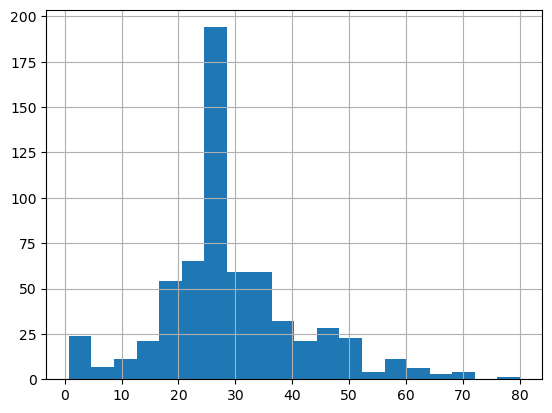

In [7]:
dftrain.age.hist(bins=20)

<Axes: ylabel='sex'>

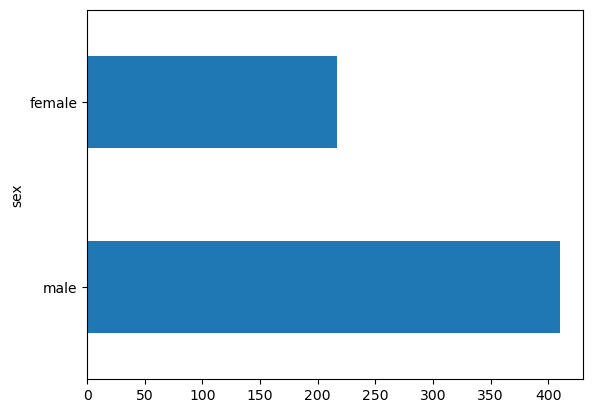

In [8]:
dftrain.sex.value_counts().plot(kind='barh')

<Axes: ylabel='class'>

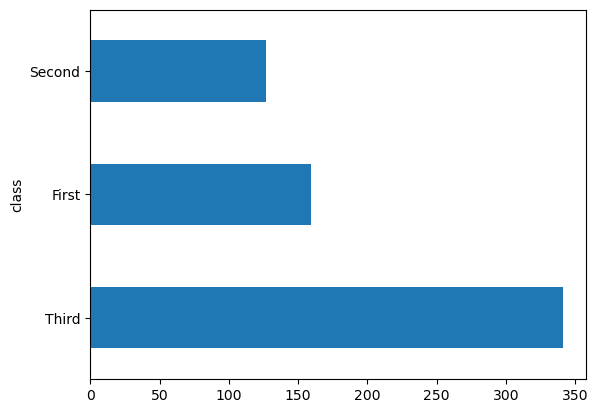

In [9]:
dftrain['class'].value_counts().plot(kind='barh')

Text(0.5, 0, '% survive')

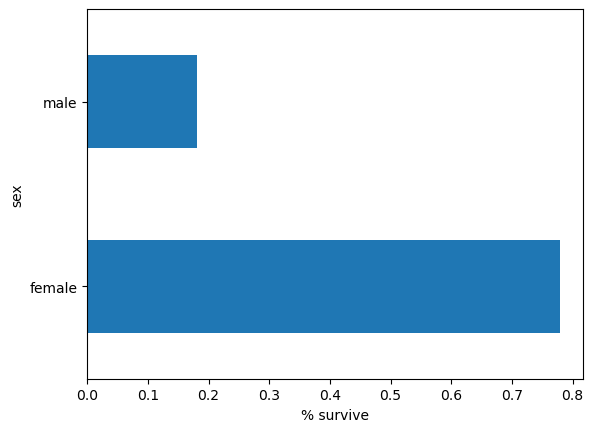

In [10]:
pd.concat([dftrain, y_train], axis=1).groupby('sex').survived.mean().plot(kind='barh').set_xlabel('% survive')

In [22]:
import tensorflow as tf
import pandas as pd
from tensorflow.keras.callbacks import TensorBoard


# Assuming dftrain and dfeval are your DataFrames for training and evaluation data
# dftrain = pd.read_csv('path_to_your_training_csv_file')
# dfeval = pd.read_csv('path_to_your_eval_csv_file')

log_dir = "logs/fit/"  # Directory where the logs will be saved
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

CATEGORICAL_COLUMNS = ['sex', 'n_siblings_spouses', 'parch', 'class', 'deck', 'embark_town', 'alone']
NUMERIC_COLUMNS = ['age', 'fare']

# Convert categorical columns to strings
for col in CATEGORICAL_COLUMNS:
    dftrain[col] = dftrain[col].astype(str)
    dfeval[col] = dfeval[col].astype(str)

feature_columns = CATEGORICAL_COLUMNS + NUMERIC_COLUMNS

# Custom input layer
class FeatureLayer(tf.keras.layers.Layer):
    def __init__(self, feature_columns, **kwargs):
        super(FeatureLayer, self).__init__(**kwargs)
        self.feature_columns = feature_columns
        self.lookup_layers = {
            key: tf.keras.layers.StringLookup(vocabulary=list(dftrain[key].unique()))
            for key in CATEGORICAL_COLUMNS
        }
        self.encoding_layers = {
            key: tf.keras.layers.CategoryEncoding(num_tokens=len(dftrain[key].unique()) + 1, output_mode='one_hot')
            for key in CATEGORICAL_COLUMNS
        }
    
    def call(self, inputs):
        processed_features = []
        
        # Process categorical features
        for key in CATEGORICAL_COLUMNS:
            value = inputs[key]
            index = self.lookup_layers[key](value)
            one_hot = self.encoding_layers[key](index)
            processed_features.append(one_hot)
        
        # Process numeric features
        for key in NUMERIC_COLUMNS:
            value = inputs[key]
            value = tf.reshape(value, [-1, 1])
            processed_features.append(value)
        
        # Concatenate all processed features
        feature_columns = tf.keras.layers.Concatenate()(processed_features)
        return feature_columns

# Define the model
model = tf.keras.Sequential([
    FeatureLayer(feature_columns),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model with additional metrics
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.AUC(name='auc')
    ]
)

# Define input functions
def df_to_dataset(data_df, label_df, shuffle=True, batch_size=32):
    ds = tf.data.Dataset.from_tensor_slices((dict(data_df), label_df))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(data_df))
    ds = ds.batch(batch_size)
    return ds

# Assuming you have dftrain, y_train, dfeval, and y_eval defined
train_dataset = df_to_dataset(dftrain, y_train)
eval_dataset = df_to_dataset(dfeval, y_eval, shuffle=False)

# Train the model
model.fit(train_dataset, epochs=20, callbacks=[tensorboard_callback])

# Evaluate the model
loss, accuracy, precision, recall, auc = model.evaluate(eval_dataset)
print(f"Loss: {loss}, Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, AUC: {auc}")


Epoch 1/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.6506 - auc: 0.6248 - loss: 0.8758 - precision: 0.5810 - recall: 0.4364     
Epoch 2/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6866 - auc: 0.7257 - loss: 0.5967 - precision: 0.5874 - recall: 0.5117
Epoch 3/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7221 - auc: 0.7696 - loss: 0.5765 - precision: 0.6665 - recall: 0.6891
Epoch 4/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6866 - auc: 0.7614 - loss: 0.5798 - precision: 0.6393 - recall: 0.4183
Epoch 5/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7301 - auc: 0.8094 - loss: 0.5398 - precision: 0.7607 - recall: 0.4984
Epoch 6/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7722 - auc: 0.8258 - loss: 0.5173 - precision: 0.8158 - recall: 0.5300
Epoch 7/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7606 - auc: 0.8249 - loss: 0.5218 - precision: 0.7347 - recall: 0.6062
Epoch 8/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 15

### Not bad for a first shot off the cuff. Visualization of the network in TensorBoard below.

In [24]:
# Load the TensorBoard extension
%load_ext tensorboard

# Start TensorBoard
%tensorboard --logdir logs/fit --port 6007


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6007 (pid 19720), started 0:23:38 ago. (Use '!kill 19720' to kill it.)